In [3]:
import tensorflow as tf
import sys
import os
import random
import pathlib
import natsort

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

In [4]:
# Seed 고정

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)
    # torch.manual_seed(seed) #torch를 거치는 모든 난수들의 생성순서를 고정한다
    # torch.cuda.manual_seed(seed) #cuda를 사용하는 메소드들의 난수시드는 따로 고정해줘야한다 
    # torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    # torch.backends.cudnn.deterministic = True #딥러닝에 특화된 CuDNN의 난수시드도 고정 
    # torch.backends.cudnn.benchmark = False

seed_everything()

## Load Dataset

#### Feature data

In [6]:
feature_data_dir = '../data/fundus/feature/'
feature_data_list = natsort.natsorted(os.listdir(feature_data_dir)) # data_dir 안의 파일들 읽어오기
# print(feature_data_list)

feature_data = [cv2.imread(feature_data_dir+img) for img in feature_data_list]
feature_data = [cv2.resize(img, (256, 256)) for img in feature_data]   # image resize

feature_data = np.array(feature_data)

print(f"feature_data shape: {feature_data.shape}")

feature_data shape: (499, 256, 256, 3)


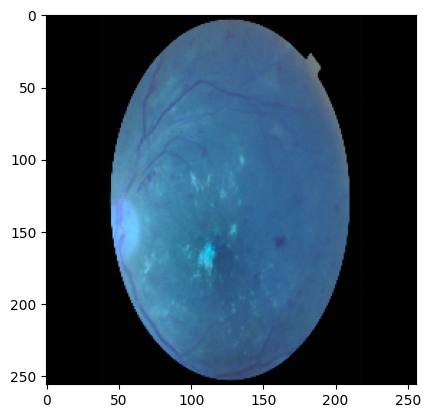

In [7]:
plt.imshow(feature_data[0])
plt.show()

#### Target data

In [8]:
target_data = pd.read_csv("../data/fundus/target/RFMiD_Testing_Labels.csv")
# target_data = target_data.drop("ID", axis=1).iloc[:500, :]
target_data = target_data.iloc[1:500, 1:]
target_data

,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,LS,...,CME,PTCR,CF,VH,MCA,VS,BRAO,PLQ,HPED,CL
1,1,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
496,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
497,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
498,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Train/Test Data split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(feature_data, target_data, test_size=0.1, random_state=42, shuffle=True)
print(f"X_train shape: {X_train.shape}, X_train shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_train shape: {y_test.shape}")

X_train shape: (449, 256, 256, 3), X_train shape: (50, 256, 256, 3)
y_train shape: (449, 46), y_train shape: (50, 46)


#### Data Scaling

In [16]:
# 차원 변환 후, 테스트셋과 학습셋으로 나누어 줍니다. One-Hot Encording
X_train = X_train.reshape(X_train.shape[0], 784).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 784).astype('float32') / 255


y_train = to_categorical(y_train, 46)
y_test = to_categorical(y_test, 46)

In [22]:
print(X_test[0].shape)

(256, 256, 3)


#### One-Hot Encoding 할 것!

In [17]:
# 바이너리화 과정을 실습해 봅니다.
y_train = to_categorical(y_train, 46)
y_test = to_categorical(y_test, 46)

print(y_train[0])

[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


### Modeling

In [18]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(256, 256, 3),   # feature 추출
                 activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))    # img size축소, 연산량을 줄임
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128,  activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(46, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 252, 252, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 126, 126, 64)      0         
                                                                 
 flatten (Flatten)           (None, 1016064)           0         
                                                                 
 dense (Dense)               (None, 128)               130056320 
                                                        

In [8]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"     # CPU사용

In [19]:
# 모델 실행 환경을 설정합니다.
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

# 모델 최적화를 위한 설정 구간입니다.
modelpath="./Fundus_CNN.keras"

# 모델을 실행합니다.
history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs=30, batch_size=16)

Epoch 1/30


ValueError: in user code:

    File "c:\Users\user\anaconda3\envs\NLP\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\user\anaconda3\envs\NLP\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\user\anaconda3\envs\NLP\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\user\anaconda3\envs\NLP\lib\site-packages\keras\engine\training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\user\anaconda3\envs\NLP\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "c:\Users\user\anaconda3\envs\NLP\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\user\anaconda3\envs\NLP\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\user\anaconda3\envs\NLP\lib\site-packages\keras\losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\user\anaconda3\envs\NLP\lib\site-packages\keras\losses.py", line 1990, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "c:\Users\user\anaconda3\envs\NLP\lib\site-packages\keras\backend.py", line 5529, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 46, 46) and (None, 46) are incompatible


In [12]:
# 모델 실행 환경을 설정합니다.
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

# 모델 최적화를 위한 설정 구간입니다.
modelpath="./Fundus_CNN.keras"
checkpointer = ModelCheckpoint(filepath=modelpath,
                               monitor='val_loss',
                               verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss',
                                        patience=10)

# 모델을 실행합니다.
history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs=30, batch_size=32,
                    verbose=0, callbacks=[early_stopping_callback,
                                          checkpointer])

# 테스트 정확도를 출력합니다.
print("\n Test Accuracy: %.4f" % (model.evaluate(X_test, y_test)[1]))


Epoch 1: val_loss improved from inf to 9692866560.00000, saving model to .\Fundus_CNN.keras

Epoch 2: val_loss did not improve from 9692866560.00000

Epoch 3: val_loss did not improve from 9692866560.00000

Epoch 4: val_loss did not improve from 9692866560.00000

Epoch 5: val_loss did not improve from 9692866560.00000

Epoch 6: val_loss did not improve from 9692866560.00000

Epoch 7: val_loss did not improve from 9692866560.00000

Epoch 8: val_loss did not improve from 9692866560.00000

Epoch 9: val_loss did not improve from 9692866560.00000

Epoch 10: val_loss did not improve from 9692866560.00000

Epoch 11: val_loss did not improve from 9692866560.00000
2/2 [==============================] - 0s 20ms/step - loss: 60728602624.0000 - accuracy: 1.0000

 Test Accuracy: 1.0000


In [15]:
pred = model.predict(X_test)
pred

2/2 [==============================] - 0s 193ms/step


array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [16]:
print(pred[0])

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [17]:
y_test

,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,LS,...,CME,PTCR,CF,VH,MCA,VS,BRAO,PLQ,HPED,CL
461,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
74,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
232,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
176,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
238,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
426,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
156,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
56,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
323,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


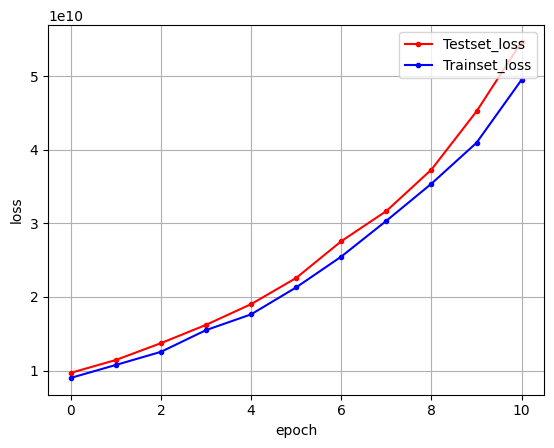

In [13]:
# 검증셋과 학습셋의 오차를 저장합니다.
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현해 봅니다.
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시해 보겠습니다.
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()